In [ ]:
#| default_exp a2a
%load_ext autoreload
%autoreload 2

In [ ]:
#| exporti
import io
import time
import random

In [ ]:
#| exporti
import torch
import torch.nn as nn
from torch.profiler import profile, record_function, ProfilerActivity, schedule

In [ ]:
#| exporti
from pathlib import Path
import json
from fastprogress import progress_bar, master_bar
import pandas as pd

In [ ]:
#| exporti
from spear_tts_pytorch.train import *
from spear_tts_pytorch.modules import *

In [ ]:
from IPython.display import Audio, HTML, display
import pylab as plt

In [ ]:
datadir = Path('/root/acoustic-6k-6454')

# Dataset

## Create a dataset index

In [ ]:
atoks = []
for name in Path(datadir).glob('*.encodec'):
    atoks.append(name)

In [ ]:
data = pd.DataFrame(dict(atoks=atoks))

In [ ]:
torch.load(atoks[0]).shape

torch.Size([1, 8, 50528])

In [ ]:
#| export
def load_data(path):
    atoks = []
    for name in Path(path).glob('*.encodec'):
        atoks.append(name)
    return pd.DataFrame(dict(atoks=atoks))

## Load the dataset index

In [ ]:
#| exporti
import torch.nn.functional as F

class SADataset(torch.utils.data.Dataset):
    def __init__(self, data, fromq=2, toq=4):
        self.fromq = fromq
        self.toq = toq
        self.n_ctx = 192
        self.data = data
        self.samples = [(i,j) for i,name in enumerate(data['atoks']) for j in range(torch.load(name).shape[-1] // self.n_ctx)]
    
    def __len__(self):
        return len(self.samples)
    
    def A_tokens(self):
        return len(self)*self.n_ctx*4
    
    def hours(self):
        return len(self)*self.n_ctx/2250*30/3600
    
    def __repr__(self):
        return f"Dataset<{len(self)} samples, ({self.fromq}->{self.toq}), {self.A_tokens()} Atokens, {self.hours():.1f} hours>"
    
    def __getitem__(self, idx):
        i,j = self.samples[idx]
        row = self.data.iloc[i]
        jA = j * self.n_ctx
        Atoks = torch.load(row['atoks'], map_location='cpu')[0,:self.toq,jA:jA+self.n_ctx].T
        outtoks = Atoks.reshape(-1).clone()
        Atoks[:,self.fromq:] = 1024 # mask token
        intoks = Atoks.reshape(-1).clone()
        return intoks, outtoks

In [ ]:
len(data)

3098

In [ ]:
val_data, train_data = data[:12], data[12:]
val_ds = SADataset(val_data)
val_ds

Dataset<5144 samples, (2->4), 3950592 Atokens, 3.7 hours>

In [ ]:
train_ds = SADataset(train_data)
train_ds

Dataset<1709062 samples, (2->4), 1312559616 Atokens, 1215.3 hours>

In [ ]:
[x.shape for x in train_ds[0]]

[torch.Size([768]), torch.Size([768])]

[<matplotlib.lines.Line2D>]

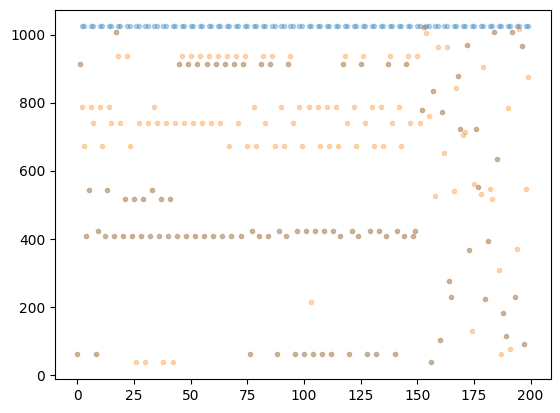

In [ ]:
plt.plot(train_ds[0][0][:200], '.', alpha=.3)
plt.plot(train_ds[0][1][:200], '.', alpha=.3)
# brown - fromq, known tokens
# blue - masked
# orange - targets

In [ ]:
#| export
def load_datasets(
        path:Path,         # encodec files path
        subsample:float=1, # use a fraction of the files
        fromq:int=2,       # input quantizers
        toq:int=8          # output quantizers
    ):
    data = load_data(path)
    
    val_data, train_data = data[:12], data[12:int(len(data)*subsample)]

    return SADataset(train_data, fromq=fromq, toq=toq), SADataset(val_data, fromq=fromq, toq=toq)

# Modeling

## Add resampled encoder features at the middle decoder layer (replacement for cross-attention)

In [ ]:
#| export
class LayerNorm(nn.LayerNorm):
    def forward(self, x):
        return super().forward(x.float()).type(x.dtype)

# based on https://github.com/karpathy/minGPT/blob/master/mingpt/model.py#L163
def init_transformer(m):
    if isinstance(m, (nn.Linear, nn.Embedding)):
        torch.nn.init.trunc_normal_(m.weight, std=.02)
        if isinstance(m, nn.Linear) and m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.LayerNorm):
        torch.nn.init.constant_(m.bias, 0)
        torch.nn.init.constant_(m.weight, 1.0)
    
class PureEncoder(nn.Module):
    def __init__(self, depth=6, width=384, n_head=6, length=1500, codes=1024, pos_embs=None):
        super().__init__()
        self.length = length
        self.codes = codes
    
        # embed semantic tokens
        self.embedding = nn.Embedding(codes+1, width)
        if pos_embs is None: pos_embs = sinusoids(length, width)
        self.register_buffer("positional_embedding", pos_embs)
        
        self.layers = nn.ModuleList([
            ResidualAttentionBlock(width, n_head) for _ in range(depth)
        ])
        self.ln_post = LayerNorm(width)
        
        self.apply(init_transformer)
        
    def forward(self, Stoks):
        Sembs = self.embedding(Stoks)

        xin = (Sembs + self.positional_embedding[:Sembs.shape[1]])
    
        x = xin
        for l in self.layers: x = l(x, causal=False)
        
        x = self.ln_post(x)
        
        logits = (x @ self.embedding.weight.to(x.dtype).T).float()
        return logits

In [ ]:
#| export
class AAARTransformer(nn.Module):
    def __init__(self, width=384, depth=4, ctx_n=250, n_head=6, fromq=2, toq=4):
        super().__init__()

        pos_embs = sinusoids(ctx_n * toq, width)
        
        self.encoder = PureEncoder(pos_embs=pos_embs, length=ctx_n*toq, width=width, n_head=n_head, depth=depth)

    def forward(self, intoks, outtoks, loss=True):
        with record_function("decoder"):
            logits = self.encoder(intoks)
        if loss is not None:
            with record_function("loss"):
                loss = F.cross_entropy(logits.reshape(-1,logits.shape[-1]), outtoks.view(-1))
        return logits, loss

In [ ]:
#| export
def make_model(size:str, dataset:torch.utils.data.Dataset=None):
    assert(dataset is not None)
    kwargs = dict(fromq = dataset.fromq, toq = dataset.toq, ctx_n = dataset.n_ctx)
    if size == 'tiny':
        return AAARTransformer(depth=4, **kwargs)
    elif size == 'base':
        return AAARTransformer(depth=6, width=512, n_head=8, **kwargs)
    elif size == 'small':
        return AAARTransformer(depth=12, width=768, n_head=12, **kwargs)

samples,train,val,time
10048,5.87283,6.50593,00:35
20032,4.60031,4.70045,01:07
30016,4.41498,4.59197,01:39
40000,6.69745,4.30315,02:12
50048,5.77218,6.70264,02:44
60032,4.36189,4.57616,03:16
70016,4.12525,4.23963,03:47
80000,4.07246,4.15308,04:22
90048,3.98553,4.10766,04:53
100032,4.03221,4.07549,05:25


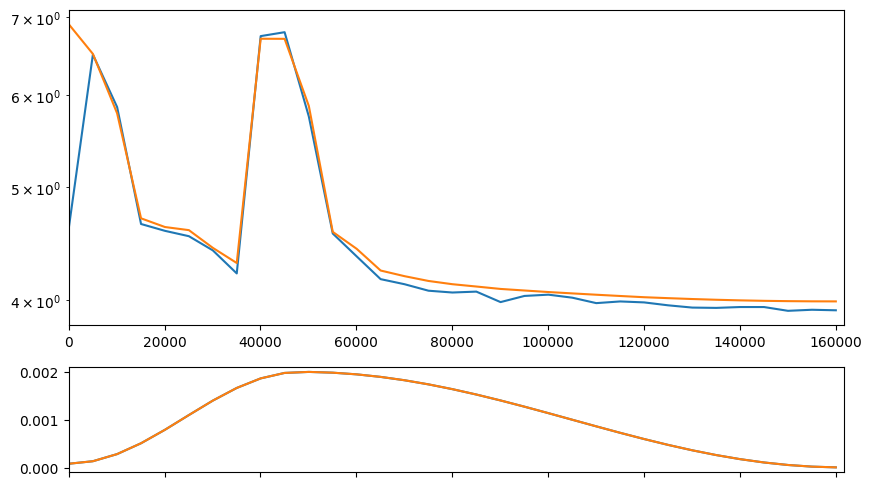

In [ ]:
train_ds, val_ds = load_datasets(datadir, subsample=.1)
model = make_model('tiny', dataset=train_ds).cuda()
train("aaar", model, train_ds, val_ds, half=True, bs=64, lr=2e-3, epochs=1,
      table_row_every_iters=10000, run_valid_every_iters=5000)

samples,train,val,time
100032,2.63314,2.94029,01:29
200000,2.38774,2.50359,02:56
300032,2.28896,2.32597,04:24
400000,2.16800,2.21409,05:51
500032,2.12749,2.14147,07:17
600000,2.02703,2.08801,08:43
700032,2.01674,2.05383,10:09
800000,2.02155,2.03176,11:36
900032,1.99235,2.01268,13:03
1000000,1.97715,1.99855,14:30


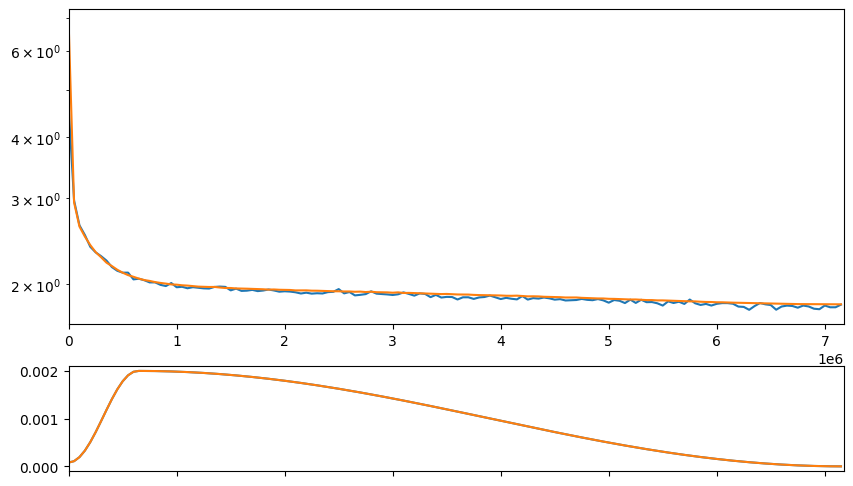

In [ ]:
# 3k prediction (2->4)
model = AAARTransformer(depth=4).cuda()
with torch.backends.cuda.sdp_kernel(enable_mem_efficient=False):
    train("aaar", model, train_ds, val_ds, half=True, bs=64, lr=2e-3, epochs=4,
          table_row_every_iters=100000, run_valid_every_iters=50000)

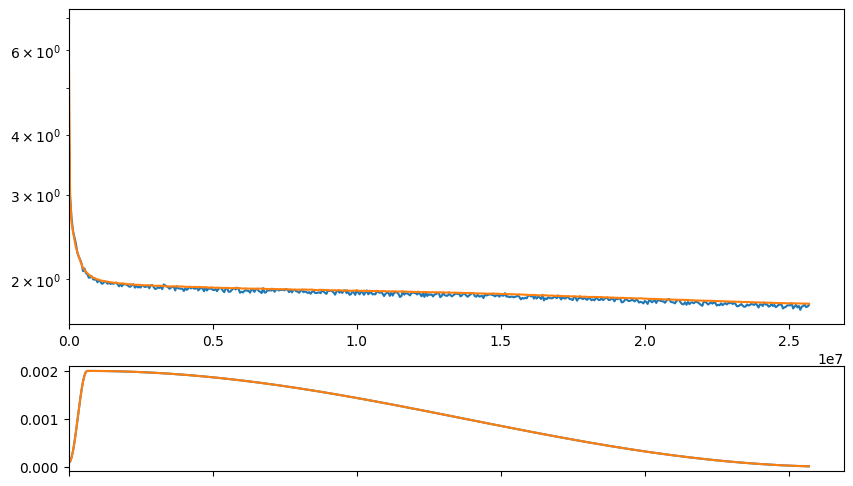

samples,train,val,time
100032,2.67010,2.95903,01:28
200000,2.45064,2.51094,02:55
300032,2.26178,2.33079,04:21
400000,2.19089,2.23048,05:48
500032,2.08060,2.14702,07:15
600000,2.05519,2.09356,08:42
700032,2.02217,2.05807,10:08
800000,2.02272,2.03556,11:35
900032,1.99063,2.01362,13:02
1000000,1.98236,2.00271,14:29


In [ ]:
# 3k prediction (2->4)
model = AAARTransformer(depth=4).cuda()
with torch.backends.cuda.sdp_kernel(enable_mem_efficient=False):
    train("aaar", model, train_ds, val_ds, half=True, bs=64, lr=2e-3, epochs=15,
          table_row_every_iters=100000, run_valid_every_iters=50000)

In [ ]:
torch.save(model.state_dict(), 'aaar-1000h-3k-15e-ce1.78.pth')

# Sample from the model

In [ ]:
state = {k.removeprefix('model.'):v for k, v in torch.load('a2a-2t4.ckpt')['state_dict'].items()}

In [ ]:
model1 = make_model('base', load_datasets(datadir, subsample=.1, fromq=2, toq=4)[0]).cuda()
model1.load_state_dict(state)
model1.eval().cuda();

In [ ]:
state = {k.removeprefix('model.'):v for k, v in torch.load('a2a-4t6.ckpt')['state_dict'].items()}

In [ ]:
model2 = make_model('base', load_datasets(datadir, subsample=.1, fromq=4, toq=6)[0]).cuda()
model2.load_state_dict(state)
model2.eval().cuda();

In [ ]:
state = {k.removeprefix('model.'):v for k, v in torch.load('a2a-6t8')['state_dict'].items()}

In [ ]:
model3 = make_model('base', load_datasets(datadir, subsample=.1, fromq=6, toq=8)[0]).cuda()
model3.load_state_dict(state)
model3.eval().cuda();

In [ ]:
from encodec.model import EncodecModel
Amodel = EncodecModel.encodec_model_24khz()
Amodel.set_target_bandwidth(6)
Amodel.cuda().eval();

In [ ]:
import torchaudio

def save_wav(name, Atoks, codes=4):
    with torch.no_grad():
        audio = Amodel.decode([(Atoks.reshape(-1,codes).T.unsqueeze(0), torch.tensor(1).cuda())])[0]
    torchaudio.save(name, audio.cpu(), 24000)
    display(HTML(f'<a href="{name}" target="_blank">Listen to sample {name}</a>'))

In [ ]:
dl = torch.utils.data.DataLoader(SADataset(val_data, fromq=2, toq=8), batch_size=16)

In [ ]:
dl.dataset

Dataset<5144 samples, (2->8), 3950592 Atokens, 3.7 hours>

In [ ]:
bx, by = [x.cuda().reshape((x.shape[0],-1,8)) for x in next(iter(dl))]

In [ ]:
bx.shape, by.shape

(torch.Size([16, 192, 8]), torch.Size([16, 192, 8]))

In [ ]:
val_ds[0][0][:8]

tensor([  62,  913, 1024, 1024,   62,  424, 1024, 1024])

In [ ]:
bx[:2,:4].reshape(-1)

tensor([  62,  913, 1024, 1024, 1024, 1024, 1024, 1024,   62,  424, 1024, 1024,
        1024, 1024, 1024, 1024,   62,  424, 1024, 1024, 1024, 1024, 1024, 1024,
          62,  424, 1024, 1024, 1024, 1024, 1024, 1024,  103,  420, 1024, 1024,
        1024, 1024, 1024, 1024,  148,  973, 1024, 1024, 1024, 1024, 1024, 1024,
         537,  652, 1024, 1024, 1024, 1024, 1024, 1024,  935,  652, 1024, 1024,
        1024, 1024, 1024, 1024], device='cuda:0')

In [ ]:
by[:2,:4].reshape(-1)

tensor([  62,  913,  786,  215,  528, 1011, 1002,  948,   62,  424,  786,  215,
         448,  986,  570,  975,   62,  424,  786,  741,  622,  986, 1002,  948,
          62,  424,  786,  741,  622,  986, 1002,  948,  103,  420,  878,  540,
         984,  744,  664,  506,  148,  973,  872,  359,  962,  800,  355,  940,
         537,  652,  242, 1016,  983,  919,  605,  660,  935,  652,  767,  940,
         446,  439,  543,  831], device='cuda:0')

In [ ]:
model1.encoder.positional_embedding.shape

torch.Size([768, 512])

In [ ]:
def fwd(model, bx, by=None):
    logits = []
    loss = 0
    with torch.no_grad():
        for i in range(len(bx)):
            _logits, _loss = model(bx[i:i+1].reshape(1,-1), by is not None and by[i:i+1].reshape(1,-1), loss=by)
            logits.append(_logits)
            if by is not None:
                loss += _loss
    logits = torch.cat(logits)
    return logits, loss/len(bx)

In [ ]:
logits, loss = fwd(model1, bx[:,:,:4], by[:,:,:4])
p = logits.argmax(-1).reshape(logits.shape[0],-1,4)
loss

tensor(1.8225, device='cuda:0')

In [ ]:
logits.shape

torch.Size([16, 768, 1025])

In [ ]:
bx.shape, p.shape

(torch.Size([16, 192, 8]), torch.Size([16, 192, 4]))

In [ ]:
(by[:,:,2:4] == p[:,:,2:4]).float().mean()

tensor(0.1947, device='cuda:0')

In [ ]:
bx.shape

torch.Size([16, 192, 8])

In [ ]:
save_wav("ref-1.5k.wav", bx[:,:,:2], codes=2)

In [ ]:
save_wav("ref-3k.wav", by.reshape(-1,4)[:,:], codes=4)

In [ ]:
save_wav('test-3k.wav', p, codes=4)

In [ ]:
bx2 = torch.cat([p[:,:,:4], torch.full((by.shape[0], by.shape[1], 2), 1024).cuda()], dim=-1)
bx2.shape

torch.Size([16, 192, 6])

In [ ]:
logits, _ = fwd(model2, bx2.reshape(p.shape[0],-1))
p2 = logits.argmax(-1).reshape(bx2.shape)

In [ ]:
p2.shape

torch.Size([16, 192, 6])

In [ ]:
save_wav('test-4.5k.wav', p2, codes=6)

In [ ]:
bx3 = torch.cat([p2[:,:,:6], torch.full((by.shape[0], by.shape[1], 2), 1024).cuda()], dim=-1)
bx3.shape

torch.Size([16, 192, 8])

In [ ]:
logits, _ = fwd(model3, bx3.reshape(p.shape[0],-1))
p3 = logits.argmax(-1).reshape(bx3.shape)

In [ ]:
by.shape

torch.Size([16, 192, 8])

In [ ]:
save_wav('test-6k.wav', p3, codes=8)

In [ ]:
save_wav('ref-6k.wav', by, codes=8)

In [ ]:
(p3 == by).float().mean()

tensor(0.3344, device='cuda:0')